In [1]:
'''
Train/test split 75/25
~50 iterations

Document:
What you’re trying to do
What you expect
parameters/code/etc.
What you received
Any relevant output figures



the "Outcome" column in the dataframe is the 0s and 1s and indicates whether the node is in the SOZ or not. these will be the "y" values in the model

get_df_list gets you a list of all the dataframes for positive patients. use this to run your analysis on each dataframe

concat_dfs gets you one big dataframe for all positive patients. run analysis on this as well.

base_path = a local location to a folder, in which you have stored all the downloaded patient folders from Mark's onedrive link. 

Important notes here: 
For patients PY18N013 and PY19N011, you need to go into the ResponseInfo folder and make a folder called CCEP and put the response files inside.
Also remember not to train on "flipped" and "significant" columns


'''

'\nTrain/test split 75/25\n~50 iterations\n\nDocument:\nWhat you’re trying to do\nWhat you expect\nparameters/code/etc.\nWhat you received\nAny relevant output figures\n\n\n\nthe "Outcome" column in the dataframe is the 0s and 1s and indicates whether the node is in the SOZ or not. these will be the "y" values in the model\n\nget_df_list gets you a list of all the dataframes for positive patients. use this to run your analysis on each dataframe\n\nconcat_dfs gets you one big dataframe for all positive patients. run analysis on this as well.\n\nbase_path = a local location to a folder, in which you have stored all the downloaded patient folders from Mark\'s onedrive link. \n\nImportant notes here: \nFor patients PY18N013 and PY19N011, you need to go into the ResponseInfo folder and make a folder called CCEP and put the response files inside.\nAlso remember not to train on "flipped" and "significant" columns\n\n\n'

In [2]:
import json
import glob
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from epilepsypcm.utils.make_df import make_df, get_df_list, concat_dfs

In [3]:
#Location
base_path = '/Users/samanthatam/Documents/year4/PCM/data/' #modify for your file location

#Function to get a list of all dataframes for all positive patients, in the format [patient number, df]
df_list = get_df_list(base_path, "1")
    
#Function to get the concatenated dataframe for all positive patients
all_positive_patients = concat_dfs(base_path, "1")

#drop significant and flipped columns
for i in range(len(df_list)):
    df_list[i][1].drop(columns=['chNames', 'flipped', 'significant'], inplace=True)
all_positive_patients.drop(columns=['chNames','flipped', 'significant'], inplace=True)

/Users/samanthatam/epilepsypcm/epilepsypcm/utils/make_df.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outcome"][df["chNames"] == channel] = 1


In [4]:
df_list[7][1]

,n1Zscore,n2Zscore,p2Zscore,n1Latency,n2Latency,p2Latency,outcome
1,41.620707,10.406610,-12.481711,29.0,276.0,72.0,0.0
5,2.358917,1.315942,-1.440858,26.0,372.0,207.0,0.0
6,2.167025,1.317880,-1.606471,33.0,701.0,117.0,0.0
7,1.615973,3.185325,-1.673670,50.0,222.0,129.0,0.0
8,0.599858,1.316393,-0.879074,21.0,228.0,137.0,0.0
...,...,...,...,...,...,...,...
2556,0.377113,0.788400,-0.356916,97.0,668.0,240.0,0.0
2557,-0.175313,-0.146884,0.650942,69.0,494.0,320.0,0.0
2558,-0.254231,-0.322911,0.657130,74.0,603.0,323.0,0.0
2560,0.635536,0.913876,-0.760027,24.0,246.0,141.0,0.0


In [5]:
all_positive_patients

,n1Zscore,n2Zscore,p2Zscore,n1Latency,n2Latency,p2Latency,outcome
2,1.396644,1.062212,-5.025081,13.0,180.0,43.0,1.0
6,1.371992,1.735958,-0.305671,17.0,131.0,47.0,0.0
7,1.990935,0.596185,0.596185,19.0,101.0,101.0,0.0
10,4.324042,4.524443,-1.176967,16.0,101.0,45.0,1.0
11,4.214433,2.351241,-1.154445,15.0,110.0,43.0,1.0
...,...,...,...,...,...,...,...
706,-0.775927,-2.579947,4.290270,51.0,285.0,195.0,0.0
707,1.769931,5.228859,-3.093837,12.0,139.0,69.0,0.0
708,1.361718,2.097774,-1.999799,14.0,338.0,278.0,0.0
709,-2.863802,-2.631576,7.996893,44.0,228.0,118.0,0.0


In [6]:
#seperate dataframes for class
df_majority = all_positive_patients[all_positive_patients.outcome==0]
df_minority = all_positive_patients[all_positive_patients.outcome==1]

from sklearn.utils import resample

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= all_positive_patients["outcome"].value_counts()[0.0],    # to match majority class
                                 random_state=123) # reproducible results

#combine dataframes
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

#downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples= all_positive_patients["outcome"].value_counts()[1.0],     # to match minority class
                                 random_state=123) # reproducible results

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

<Figure size 432x288 with 0 Axes>

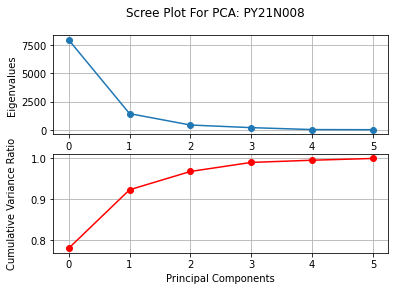

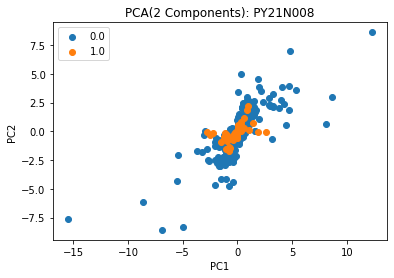

<Figure size 432x288 with 0 Axes>

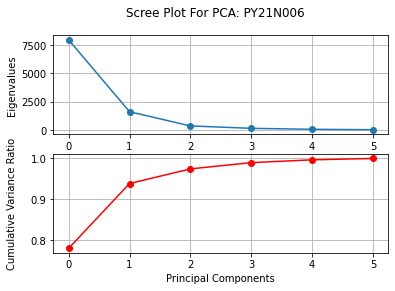

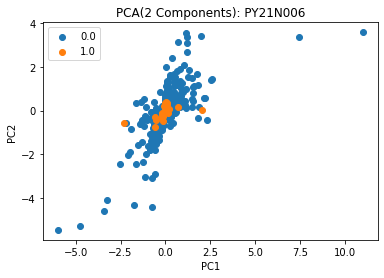

<Figure size 432x288 with 0 Axes>

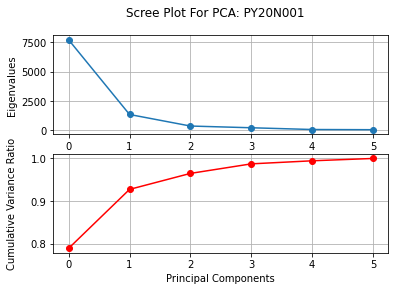

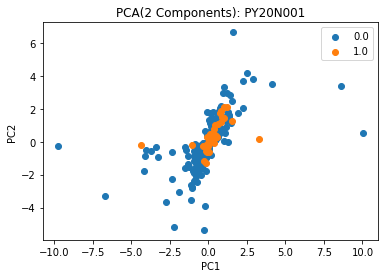

<Figure size 432x288 with 0 Axes>

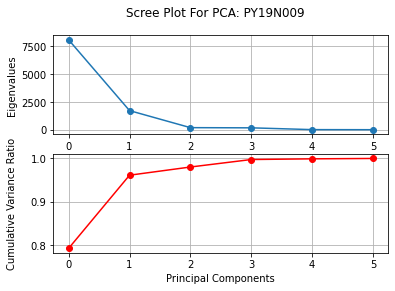

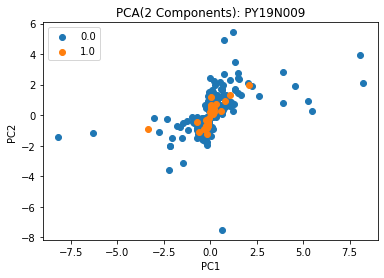

<Figure size 432x288 with 0 Axes>

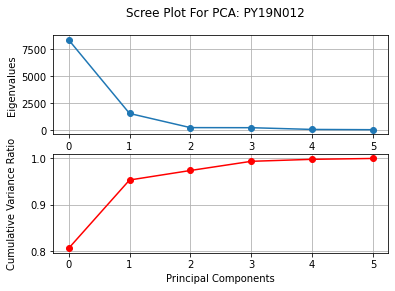

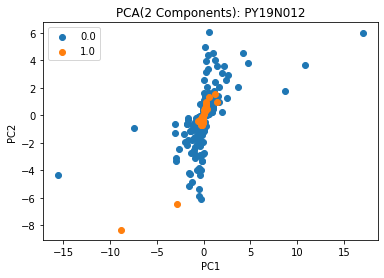

<Figure size 432x288 with 0 Axes>

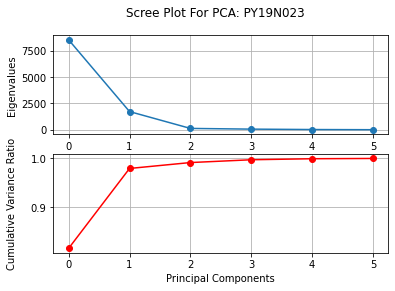

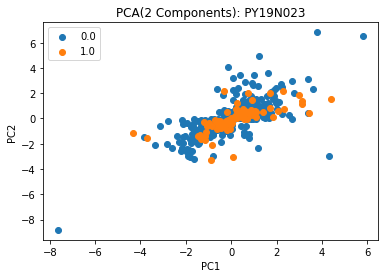

<Figure size 432x288 with 0 Axes>

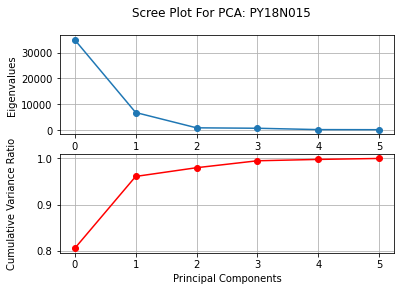

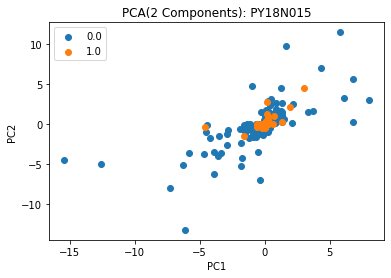

<Figure size 432x288 with 0 Axes>

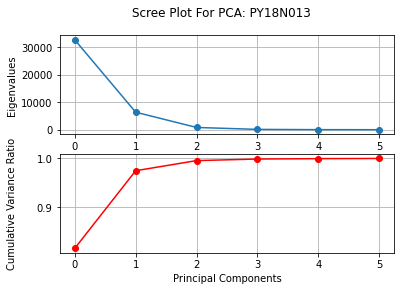

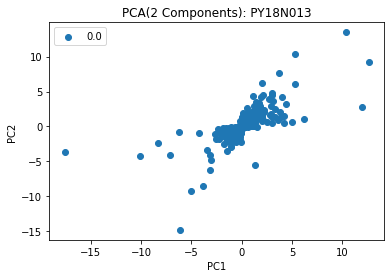

<Figure size 432x288 with 0 Axes>

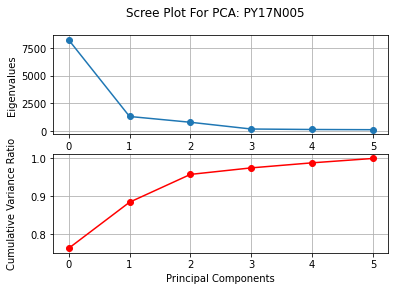

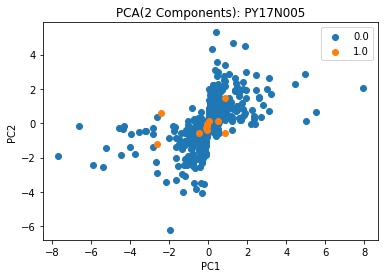

<Figure size 432x288 with 0 Axes>

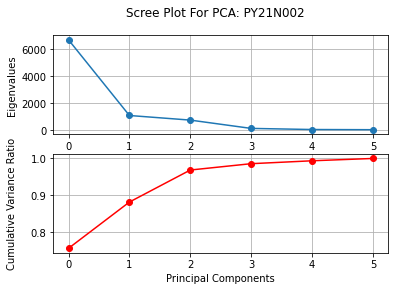

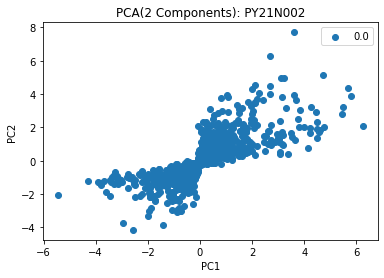

<Figure size 432x288 with 0 Axes>

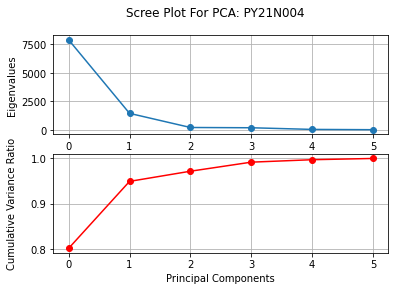

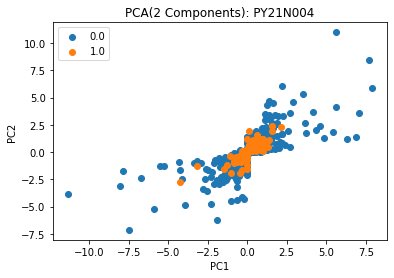

<Figure size 432x288 with 0 Axes>

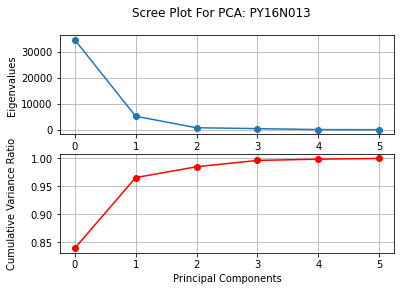

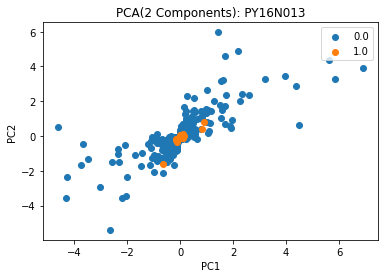

<Figure size 432x288 with 0 Axes>

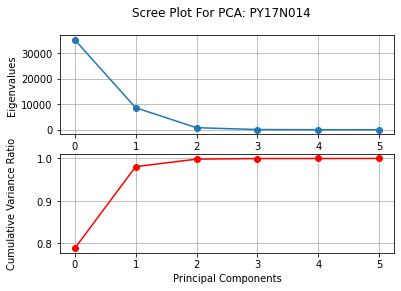

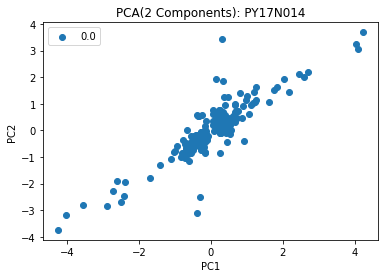

<Figure size 432x288 with 0 Axes>

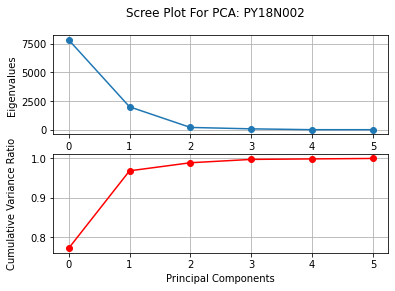

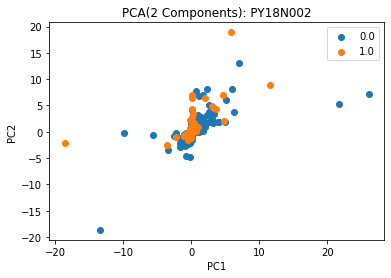

<Figure size 432x288 with 0 Axes>

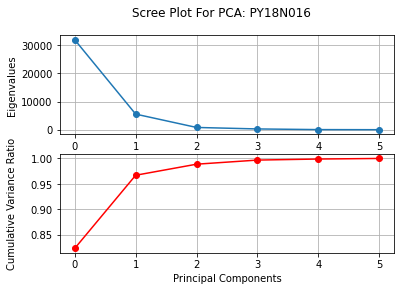

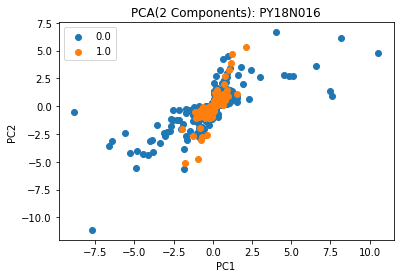

<Figure size 432x288 with 0 Axes>

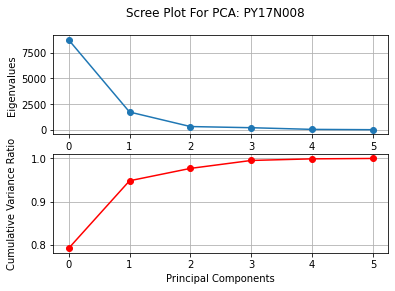

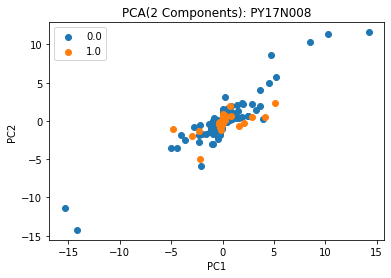

<Figure size 432x288 with 0 Axes>

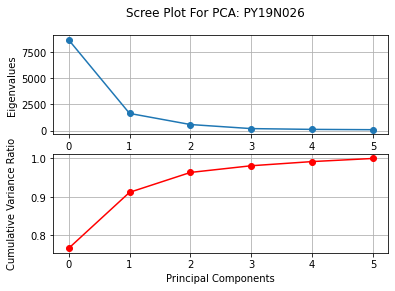

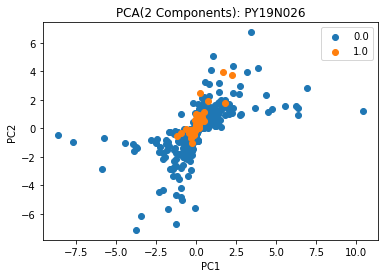

<Figure size 432x288 with 0 Axes>

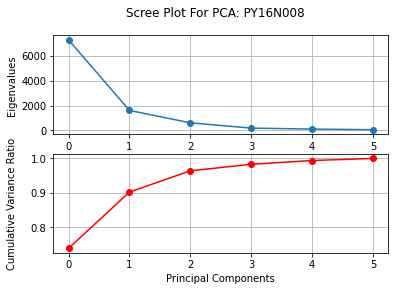

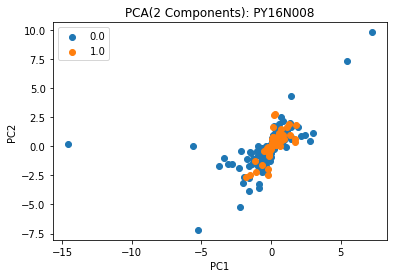

In [7]:
for i in range(len(df_list)):
    #df_list[i][1].drop(columns=['flipped', 'significant'], inplace=True)
    X = df_list[i][1].drop(columns=['outcome'])
    new = StandardScaler().fit_transform(X)
    y = df_list[i][1]['outcome']
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    pca = PCA(n_components=6)
    pca.fit_transform(X)
    L = pca.explained_variance_ 
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.align_ylabels()
    fig.suptitle('Scree Plot For PCA: %s' % df_list[i][0])

    ax1.plot(L,'o-')
    ax1.set_ylabel('Eigenvalues')
    ax1.grid()

    cmsm = np.cumsum(L)
    ax2.plot(cmsm/cmsm[-1],'o-r')
    ax2.set_xlabel('Principal Components')
    ax2.set_ylabel('Cumulative Variance Ratio');
    ax2.grid()
    plt.show() 
    
    plt.figure()
    for label in np.unique(y):
        plt.scatter(new[y==label, 0], new[y==label, 1], label=label)

    plt.title('PCA(2 Components): %s' % df_list[i][0])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.show()
    


<Figure size 432x288 with 0 Axes>

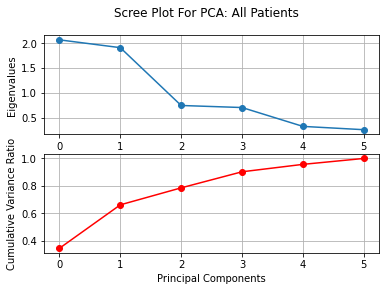

In [8]:
X = all_positive_patients.drop(columns=['outcome'])
scaled = StandardScaler().fit_transform(X)
y = all_positive_patients['outcome']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
pca = PCA(n_components=6)
pca.fit(scaled)
X_new = pca.transform(scaled)
L = pca.explained_variance_ 

plt.figure()
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.align_ylabels()
fig.suptitle('Scree Plot For PCA: All Patients')

ax1.plot(L,'o-')
ax1.set_ylabel('Eigenvalues')
ax1.grid()

cmsm = np.cumsum(L)
ax2.plot(cmsm/cmsm[-1],'o-r')
ax2.set_xlabel('Principal Components')
ax2.set_ylabel('Cumulative Variance Ratio');
ax2.grid()

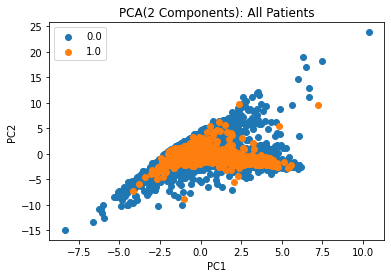

In [9]:
pca = PCA(n_components=2)
new = pca.fit_transform(scaled)

for label in np.unique(y):
    plt.scatter(new[y==label, 0], new[y==label, 1], label=label)

plt.title('PCA(2 Components): All Patients')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

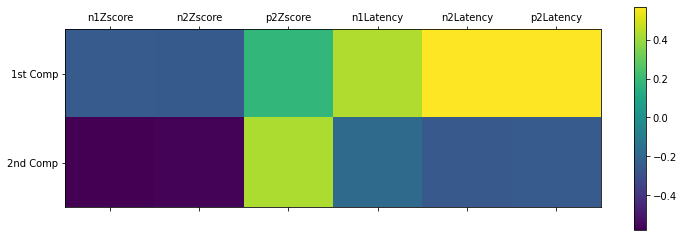

In [10]:
plt.matshow(pca.components_)
plt.yticks([0,1], ['1st Comp', '2nd Comp'])
plt.xticks(range(len(X.columns.values)), X.columns.values)
plt.colorbar()
plt.show

<Figure size 432x288 with 0 Axes>

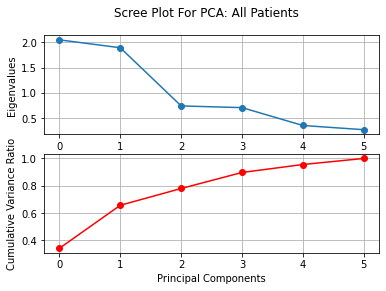

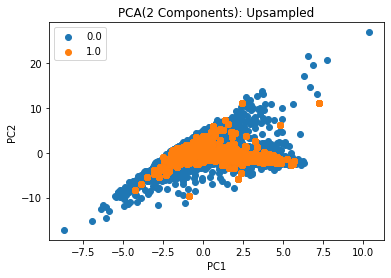

In [11]:
#df_upsampled
X = df_upsampled.drop(columns=['outcome'])
scaled = StandardScaler().fit_transform(X)
y = df_upsampled['outcome']

pca = PCA(n_components=6)
pca.fit(scaled)
X_new = pca.transform(scaled)
L = pca.explained_variance_ 

plt.figure()
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.align_ylabels()
fig.suptitle('Scree Plot For PCA: All Patients')

ax1.plot(L,'o-')
ax1.set_ylabel('Eigenvalues')
ax1.grid()

cmsm = np.cumsum(L)
ax2.plot(cmsm/cmsm[-1],'o-r')
ax2.set_xlabel('Principal Components')
ax2.set_ylabel('Cumulative Variance Ratio');
ax2.grid()
plt.show()

pca = PCA(n_components=2)
new = pca.fit_transform(scaled)

for label in np.unique(y):
    plt.scatter(new[y==label, 0], new[y==label, 1], label=label)

plt.title('PCA(2 Components): Upsampled')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

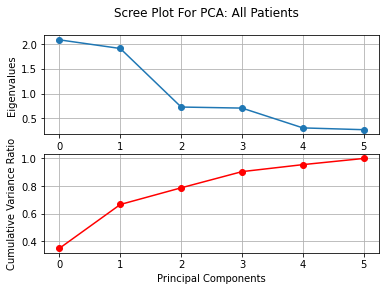

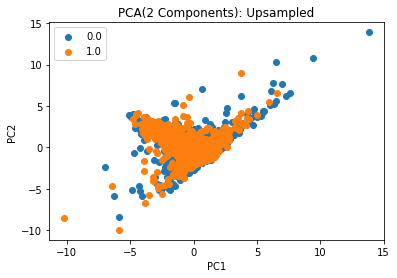

In [12]:
#df_downsampled
X = df_downsampled.drop(columns=['outcome'])
scaled = StandardScaler().fit_transform(X)
y = df_downsampled['outcome']

pca = PCA(n_components=6)
pca.fit(scaled)
X_new = pca.transform(scaled)
L = pca.explained_variance_ 

plt.figure()
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.align_ylabels()
fig.suptitle('Scree Plot For PCA: All Patients')

ax1.plot(L,'o-')
ax1.set_ylabel('Eigenvalues')
ax1.grid()

cmsm = np.cumsum(L)
ax2.plot(cmsm/cmsm[-1],'o-r')
ax2.set_xlabel('Principal Components')
ax2.set_ylabel('Cumulative Variance Ratio');
ax2.grid()
plt.show()

pca = PCA(n_components=2)
new = pca.fit_transform(scaled)

for label in np.unique(y):
    plt.scatter(new[y==label, 0], new[y==label, 1], label=label)

plt.title('PCA(2 Components): Upsampled')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()